In [1]:
import os, sys
ROOT = os.path.abspath("..")
sys.path.append(os.path.join(ROOT, "src"))
import numpy as np
import yaml
from gym_env.ref_env import Ref, make_env
from helpers import helper as h
from helpers import device as d

import gymnasium as gym

# import stablebaselines
from stable_baselines3 import PPO, SAC, DDPG, TD3, A2C
from stable_baselines3.common.vec_env import DummyVecEnv, SubprocVecEnv, VecMonitor, VecNormalize
from stable_baselines3.common.utils import set_random_seed
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from wandb.integration.sb3 import WandbCallback
import gymnasium as gym

import matplotlib.pyplot as plt
from collections import Counter
import torch

In [220]:
env_name = "C1_85"
algo = "PPO"
model_name = "C1_85_H3_run_4"
timesteps = 24000000
mode = "models"  # "train" or "checkpoint" or "best_model"

### Value Function 

In [224]:
n = 60
room_1 = np.linspace(-22, -16, num=n, dtype=np.float64)
room_2 = np.linspace(-22, -16, num=n, dtype=np.float64)
mesh_x, mesh_y = np.meshgrid(room_1, room_2)
obs_array = np.stack([mesh_x.ravel(), mesh_y.ravel()], axis=1).astype(np.float64)
N = obs_array.shape[0]
obs_batch = {"room_temperatures": obs_array}



In [225]:
C_path = f'env_config/discrete_joint/{env_name}.yaml'  # Default path for environment configuration
with open(f"{ROOT}/{C_path}", 'r') as f:
        env_cfg = yaml.load(f, Loader=yaml.SafeLoader)

env_params = env_cfg.copy()
project_name = env_params['env']['name']
delta_t = env_params['env']['time_step']          # Time step in hours
total_t = env_params['env']['Total_time']          # Total simulation time in hours
timelimit = int(np.ceil(total_t / delta_t))

In [226]:
model_dir = f"{ROOT}/results/{project_name}/{env_name}/RL_Model/{algo}/{model_name}/{mode}/model.zip"
# model_dir = f"{ROOT}/results/{project_name}/{env_name}/RL_Model/{algo}/{model_name}/{mode}/best_model.zip" 
#model_dir = f"{ROOT}/results/{project_name}/{env_name}/RL_Model/{algo}/{model_name}/checkpoints/rl_model_{timesteps}_steps.zip"
model = PPO.load(model_dir)

In [ ]:
model_dir = f"{ROOT}/results/{project_name}/{env_name}/RL_Model/{algo}/{model_name}/{mode}/best_model.zip" 
model = PPO.load(model_dir)

In [182]:
model_dir = f"{ROOT}/results/{project_name}/{env_name}/RL_Model/{algo}/{model_name}/checkpoints/rl_model_{timesteps}_steps.zip"
model = PPO.load(model_dir)

In [227]:
dummy_env = DummyVecEnv([lambda: Monitor(gym.wrappers.TimeLimit(Ref(params=env_params), max_episode_steps=timelimit))])
vecnorm = VecNormalize.load(f"{ROOT}/results/{project_name}/{env_name}/RL_Model/{algo}/{model_name}/vec_normalize.pkl", dummy_env)
vecnorm.training = False
vecnorm.norm_reward = False

In [228]:
if isinstance(obs_batch, dict):
        # batch = {k: np.asarray(v, dtype=np.float64)[None, ...] for k, v in obs_batch.items()}
        normed = vecnorm.normalize_obs(obs_batch)
        obs = {k: normed[k][:] for k in normed}  # remove batch dim
else:
    batch = np.asarray(obs_batch, dtype=np.float64)[None, ...]
    obs = vecnorm.normalize_obs(batch)[0]


obs_torch, _ = model.policy.obs_to_tensor(obs)  # handles Dict → dict of tensors on device



In [229]:
with torch.no_grad():
    v_t = model.policy.predict_values(obs_torch)   # torch.tensor [N]

values = v_t.detach().cpu().numpy().reshape(mesh_x.shape)


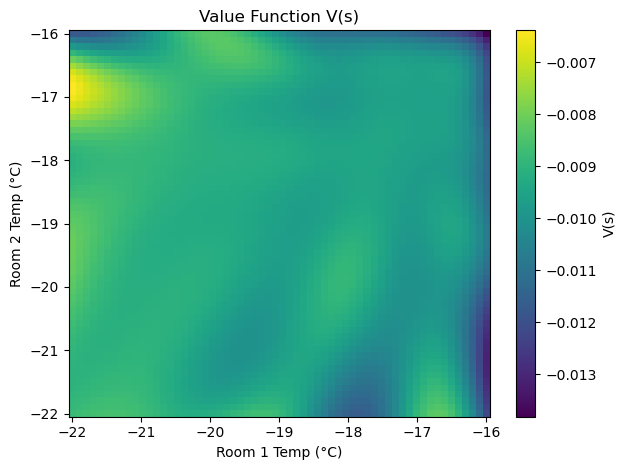

In [230]:
plt.figure()
plt.title("Value Function V(s)")
plt.xlabel("Room 1 Temp (°C)")
plt.ylabel("Room 2 Temp (°C)")
# Use pcolormesh with the meshgrid for correct axes
plt.pcolormesh(mesh_x, mesh_y, values, shading="auto")
plt.colorbar(label="V(s)")
# Optional: if you want -15 on the left/top visually:
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Policy

In [222]:
### predict discrete actions
### To get the exact action for each observation in the environment, we later take it through the set_on_off  and get_action function in the environment.
pred_actions, _ = model.predict(obs, deterministic= True)  # np.array [N,]
actions = pred_actions.reshape(mesh_x.shape)  # reshape to match the meshgrid shape


Text(0, 0.5, 'Room 2 Temp (°C)')

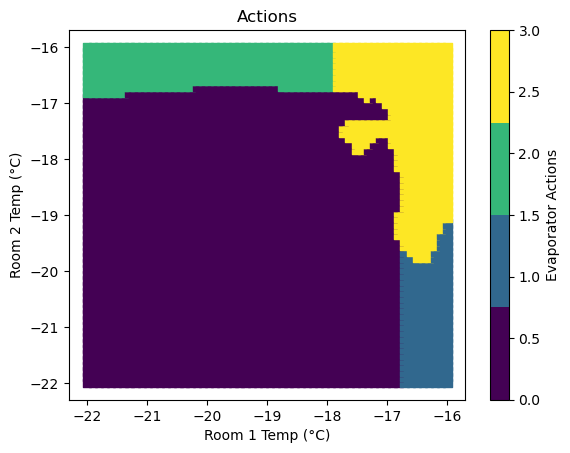

In [223]:
from matplotlib.colors import BoundaryNorm
plt.figure()
cmap = plt.get_cmap("viridis", 4)                # 4 discrete colors
norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5, 3.5], cmap.N)


color_map = plt.get_cmap("viridis", 4)  # 4 discrete colors for actions 0-3
plt.scatter(mesh_x, mesh_y, c=actions[:, :], cmap=color_map, marker='s')
plt.colorbar(label="Evaporator Actions")
plt.title("Actions")
plt.xlabel("Room 1 Temp (°C)")
plt.ylabel("Room 2 Temp (°C)")
